# Understanding machine learning using probabilistic inference


In [1]:
import numpy as np
import scipy.io
from numpy.random import multivariate_normal
from scipy.linalg import cho_factor, cho_solve
import matplotlib.pyplot as plt

In [2]:
dark = np.array([51.0, 51.0, 51.0]) / 255.0
red = np.array([141.0, 45.0, 57.0]) / 255.0
gold = np.array([174.0, 159.0, 109.0]) / 255.0
gray = np.array([175.0, 179.0, 183.0]) / 255.0
lred = np.array([1, 1, 1]) - 0.5 * (np.array([1, 1, 1]) - red)
lgold = np.array([1, 1, 1]) - 0.5 * (np.array([1, 1, 1]) - gold)

## Gaussian inference on linear functions
![alt text](./guassian.png)

## Data

In [10]:
# you can change data as you like
X = np.array([-5., 14.47368421, -3.94736842, -3.42105263, -2.89473684,
       -2.36842105, -1.84210526, -1.31578947, -0.78947368, -0.26315789,
        0.26315789,  0.78947368,  1.31578947,  1.84210526,  2.36842105,
        2.89473684,  3.42105263,  3.94736842,  4.47368421,  5.]).reshape(20,1)
Y = np.array([ 5.9555788 , -30.20466854,  -4.07732766,  -3.80423523,
        -5.54641695,  -6.49758779,   2.50363387,  -4.84736199,
         2.21816925,   1.52647205,  -0.59432226,   0.92732946,
         5.04358645,   2.77229585,   5.75286021,   4.00196636,
         1.03961295,   6.97788739,   4.15119207,   7.14118806]).reshape(20,1)

sigma = 0.4

# fetures functions:
### 1. polynomial function of degree 2


In [36]:
# feature function
def phi(a):  # phi(a) = [1,a, a**2]
    return np.power(a, range(3))

#### calculate prior and posterior

In [37]:
def GaussPDFscaled(y, m, s):  # shading
    return np.exp(-0.5 * (y - m.T) ** 2 / (s ** 2).T)

#PARAMETRIC GAUSSIAN REGRESSION IN PYTHON
def guassian_regression(X, Y, sigma):
    # first, define the prior
    F = len(phi(0))  # number of features
    # set parameters of prior on the weights
    mu = np.zeros((F, 1))
    Sigma = 10 * np.eye(F) / F  # p(w)=N(mu,Sigma)

    # construct implied prior on f_x
    n = 100  # number of grid-points, for plotting
    x = np.linspace(-8, 8, n)[:, np.newaxis]  # reshape is needed for phi to work
    m = phi(x) @ mu
    kxx = phi(x) @ Sigma @ phi(x).T  # p(f_x)=N(m,k_xx)
    s = multivariate_normal(m.flatten(), kxx + 1e-6 * np.eye(n), size=5).T
    stdpi = np.sqrt(np.diag(kxx))[:, np.newaxis]  # marginal stddev, for plotting
 
    N = len(X)  # number of data

    # evidence: p(Y) = N(Y;M,kXX + sigma**2 * no.eye(N))
    M = phi(X) @ mu
    kXX = phi(X) @ Sigma @ phi(X).T  # p(f_X) = N(M,k_XX)
    G = kXX + sigma ** 2 * np.eye(N)

    # now, do inference (i.e. construct the posterior)
    # the following in-place decomposition is the most expensive step at O(N^3):
    G = cho_factor(G)
    kxX = phi(x) @ Sigma @ phi(X).T  # Cov(f_x,f_X) = k_xX
    A = cho_solve(G, kxX.T).T  # pre-compute for re-use (but is only O(N^2))

    # # posterior p(f_x|Y) = N(f_x,mpost,vpost)
    mpost = m + A @ (Y - M)  # mean
    vpost = kxx - A @ kxX.T  # covariance
    spost = multivariate_normal(mpost.flatten(), vpost  + 1e-6 * np.eye(n), size=5).T  # samples
    stdpo = np.sqrt(np.diag(vpost))[:, np.newaxis]  # marginal stddev, for plotting
    
    
    plt.rcParams["figure.figsize"] = (25, 10)
    fig, ax = plt.subplots(1, 2)
   
    yy = np.linspace(-15, 20, 200).reshape([200, 1])
    P = GaussPDFscaled(yy, m, stdpi)

    ax[0].imshow(
        P, extent=[-8, 8, -15, 20], aspect="auto", origin="lower", cmap="Greys", alpha=0.4
    )
    ax[0].plot(x, phi(x), "-", color=gold)
    ax[0].plot(x, s, ":", color=red)  # prior
    ax[0].plot(x, m, "-", color=red)
    ax[0].plot(x, m + 2 * stdpi, "-", color=lred)
    ax[0].plot(x, m - 2 * stdpi, "-", color=lred)
    ax[0].set(xlim=[-8, 8], ylim=[-15, 20], title="prior")

    Ppost = GaussPDFscaled(yy, mpost, stdpo)  # shading by local marginal pdf
    ax[1].imshow(
        Ppost,
        extent=[-8, 8, -15, 20],
        aspect="auto",
        origin="lower",
        cmap="Greys",
        alpha=0.4,
    )
    ax[1].errorbar(X.flatten(), Y.flatten(), yerr=sigma, fmt="ok")  # data
    ax[1].plot(x, mpost, "-", color=red)  # posterior mean
    ax[1].plot(x, mpost + 2 * stdpo, "-", color=lred)  # upper error bars on f
    ax[1].plot(x, mpost - 2 * stdpo, "-", color=lred)  # lower error bars on f

    ax[1].plot(
        x, mpost + 2 * stdpo + 2 * sigma, "-", color=gold
    )  # predictive error bars (on y)
    ax[1].plot(x, mpost - 2 * stdpo - 2 * sigma, "-", color=gold)

    ax[1].plot(x, spost, ":", color=red)  # samples
    ax[1].set(xlim=[-8, 8], ylim=[-15, 20], title="posterior")
    plt.show()

## showing distribution

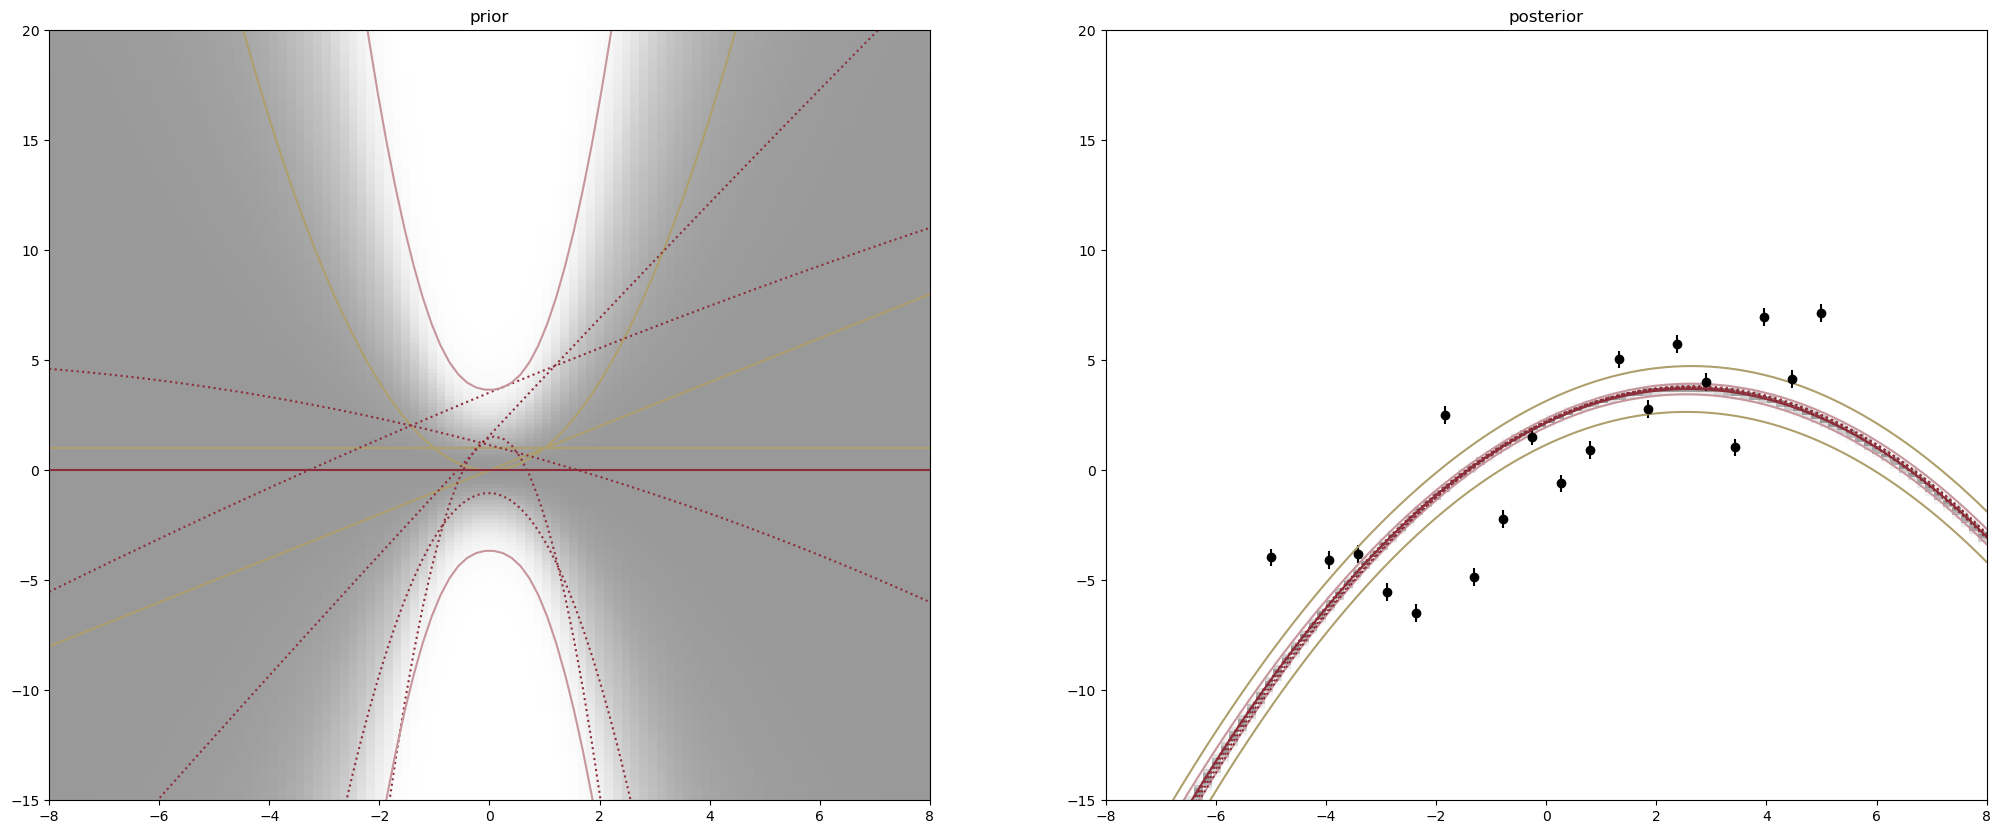

In [38]:
guassian_regression(X,Y,sigma)


## Let's play wiht Other feature functions 
Some other options for the feature functions to try. Try around! Try scaling and changing the prior and/or the features (note that there are a few degrees of freedom shared between them)

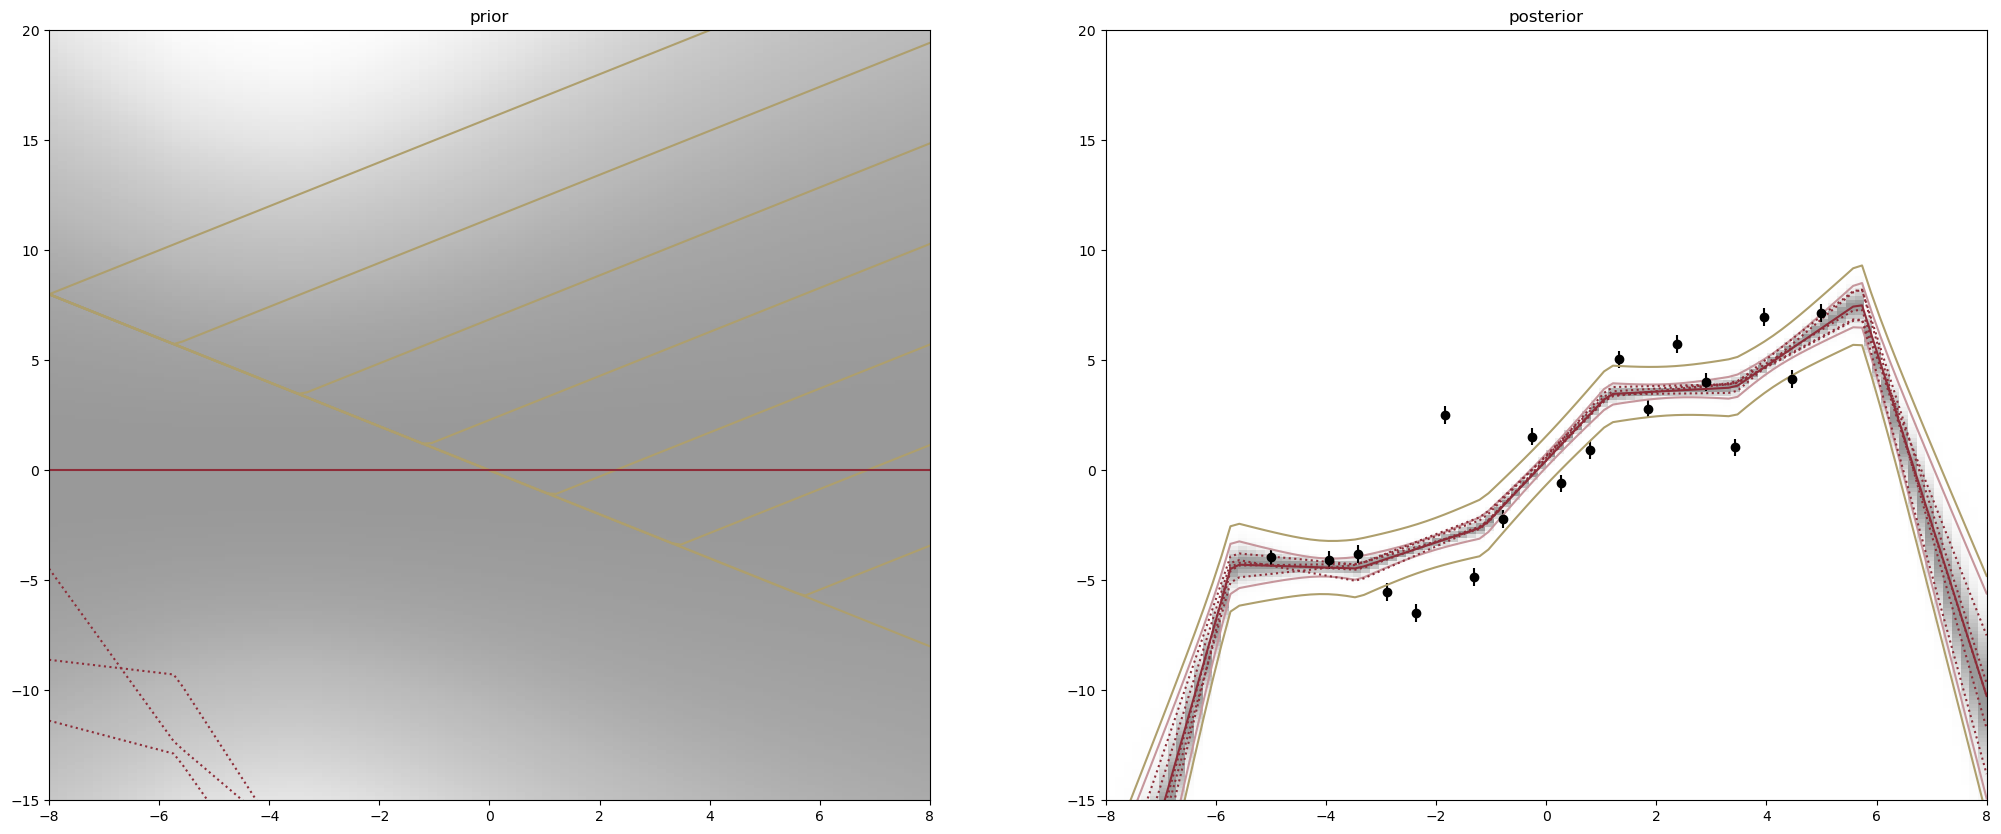

In [39]:
def phi(a):
    # linear
    return 1 * (np.abs(a - np.linspace(-8, 8, 8).T)) - np.linspace(-8, 8, 8)

guassian_regression(X,Y,sigma)

C:\Users\Dell\AppData\Local\Temp\ipykernel_8780\740267219.py:2: RuntimeWarning: divide by zero encountered in true_divide
  return np.exp(-0.5 * (y - m.T) ** 2 / (s ** 2).T)


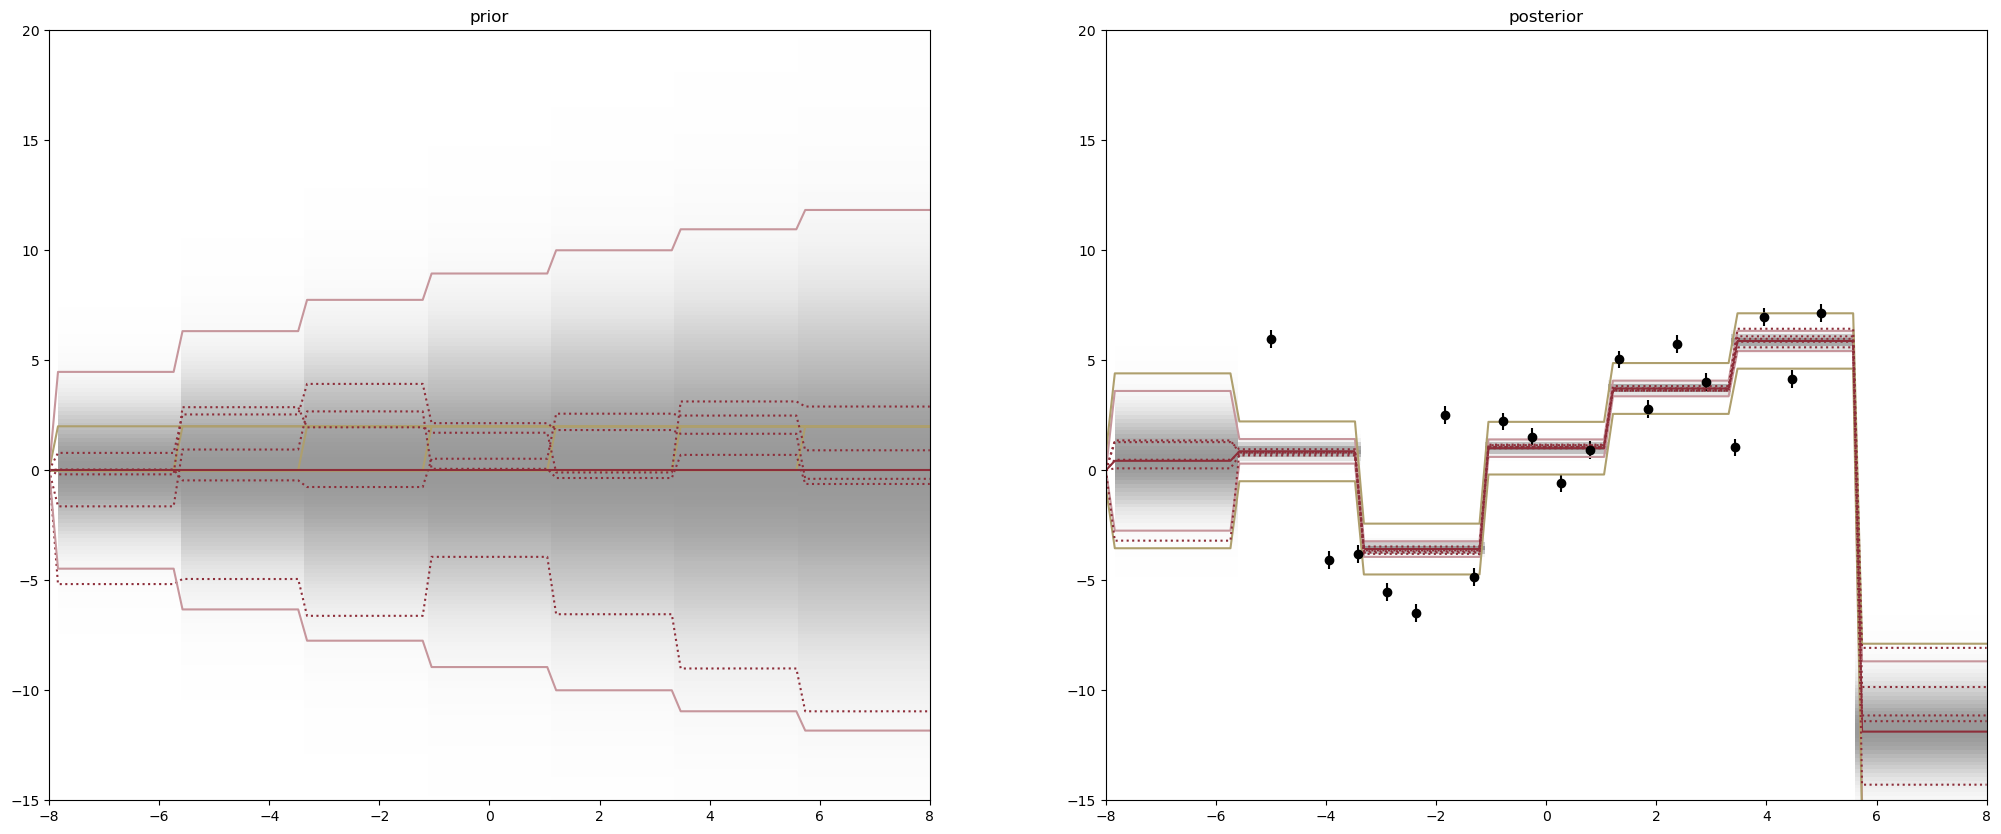

In [24]:
def phi(a):
    return 2 * (a > np.linspace(-8, 8, 8).T)  # steps that switch on

guassian_regression(X,Y,sigma)

### let's change data too

In [25]:
X = np.random.rand(22,1)*20 - 10
Y = np.random.rand(22,1)*10 - 5

sigma = np.random.rand()

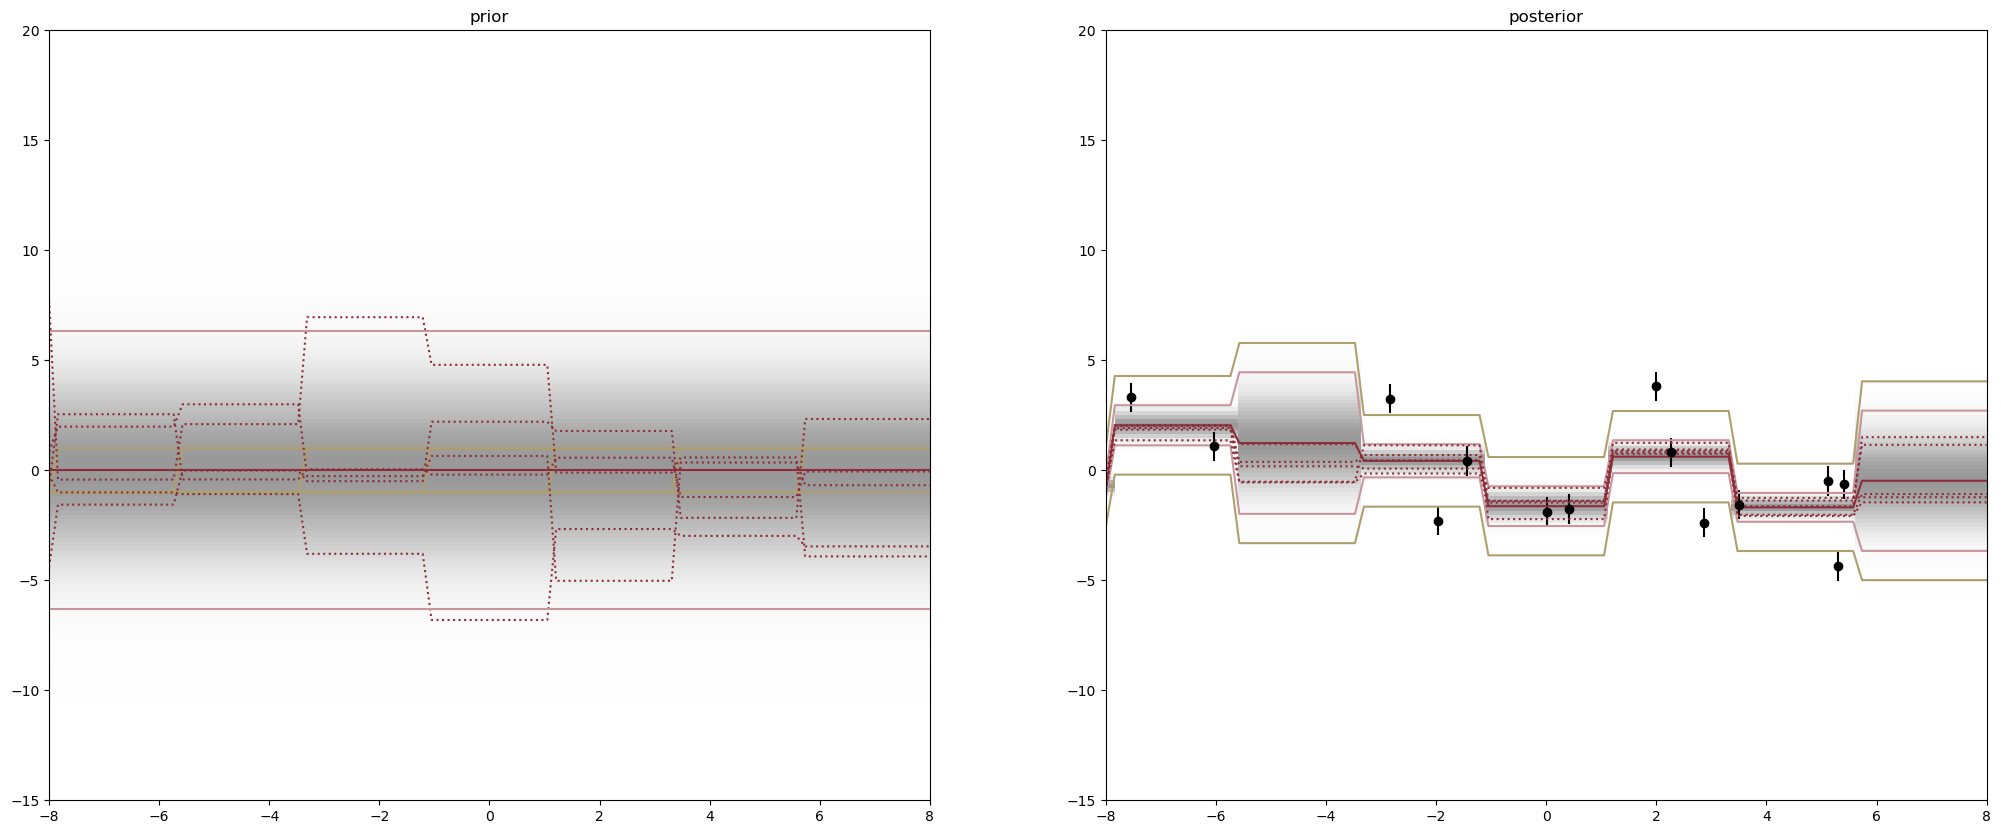

In [26]:
def phi(a):  # steps that change sign
    return 2 * ((a > np.linspace(-8, 8, 8).T) - 0.5)
guassian_regression(X,Y,sigma)

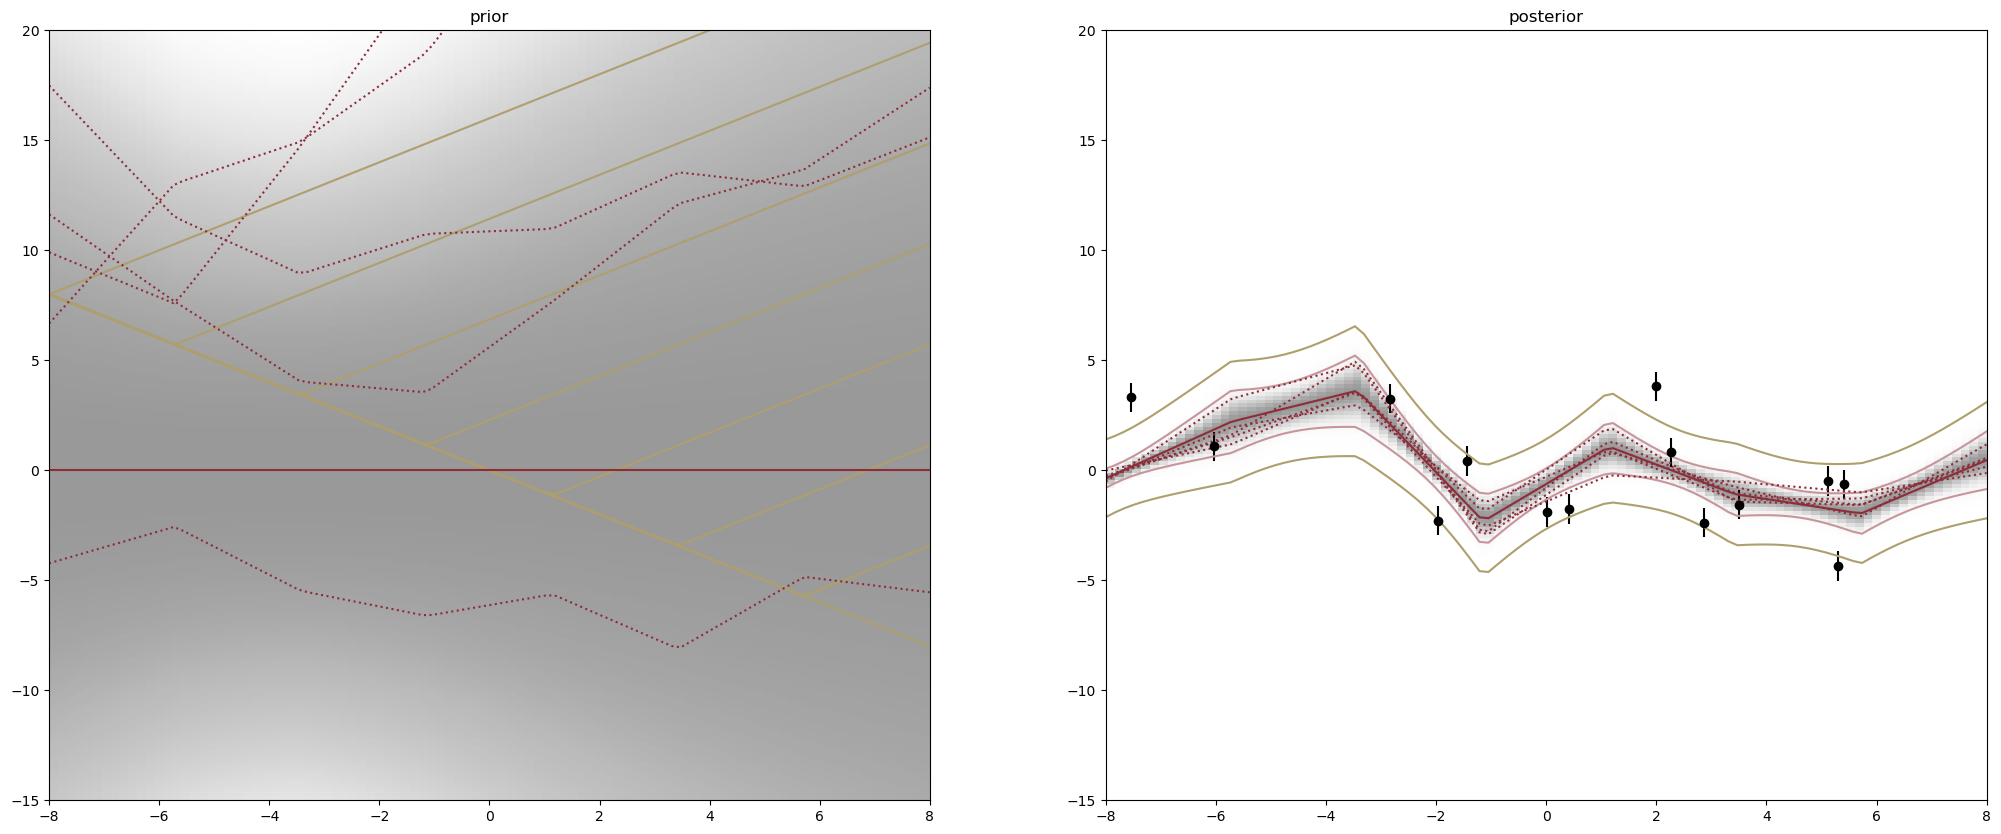

In [27]:
def phi(a):
    # linear
    return 1 * (np.abs(a - np.linspace(-8, 8, 8).T) - np.linspace(-8, 8, 8))

guassian_regression(X,Y,sigma)

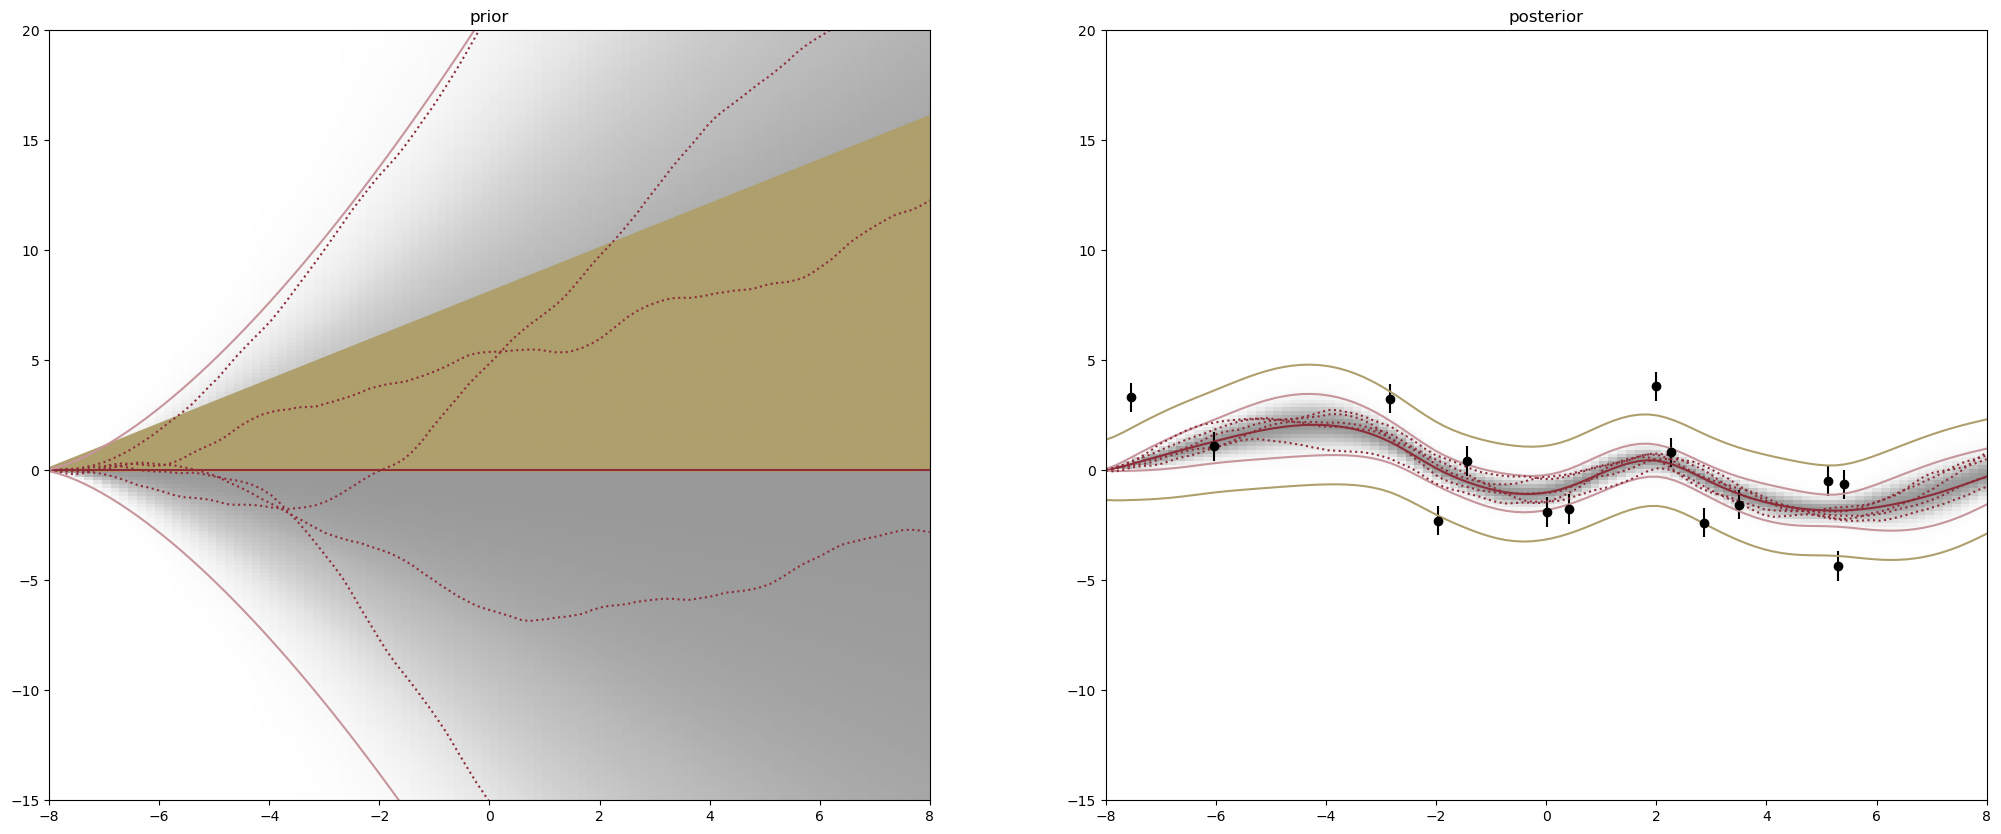

In [28]:
def phi(a):
    # ReLU: 
    F = 265
    return 1 * (a - np.linspace(-8.1, 8, F).T) * (a > np.linspace(-8.1, 8, F).T)

guassian_regression(X,Y,sigma)

### let's coose another data

In [29]:
X = np.array([-5., 14.47368421, -3.94736842, -3.42105263, -2.89473684,
       -2.36842105, -1.84210526, -1.31578947, -0.78947368, -0.26315789,
        0.26315789,  0.78947368,  1.31578947,  1.84210526,  2.36842105,
        2.89473684,  3.42105263,  3.94736842,  4.47368421,  5.]).reshape(20,1)
Y = np.array([ -3.9555788 , -30.20466854,  -4.07732766,  -3.80423523,
        -5.54641695,  -6.49758779,   2.50363387,  -4.84736199,
         -2.21816925,   1.52647205,  -0.59432226,   0.92732946,
         5.04358645,   2.77229585,   5.75286021,   4.00196636,
         1.03961295,   6.97788739,   4.15119207,   7.14118806]).reshape(20,1)

sigma = 0.4

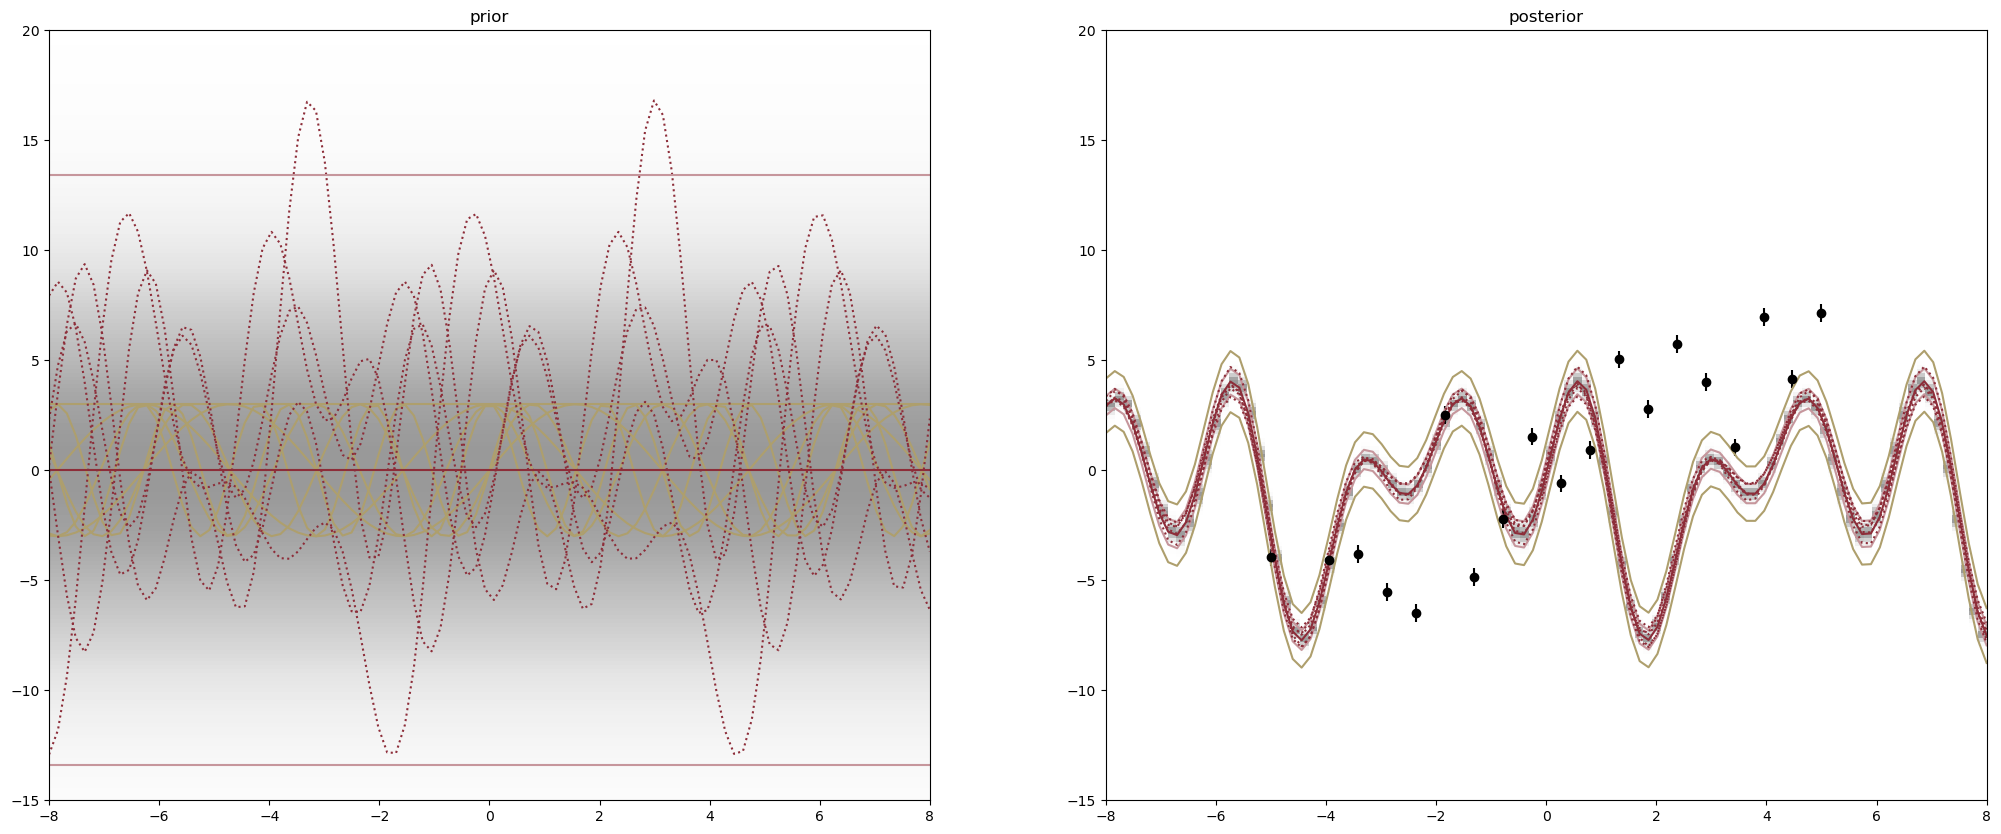

In [30]:
def phi(a):  # Fourier features
    return 3 * np.hstack((np.sin(a * np.arange(4)), np.cos(a * np.arange(4))))

guassian_regression(X,Y,sigma)

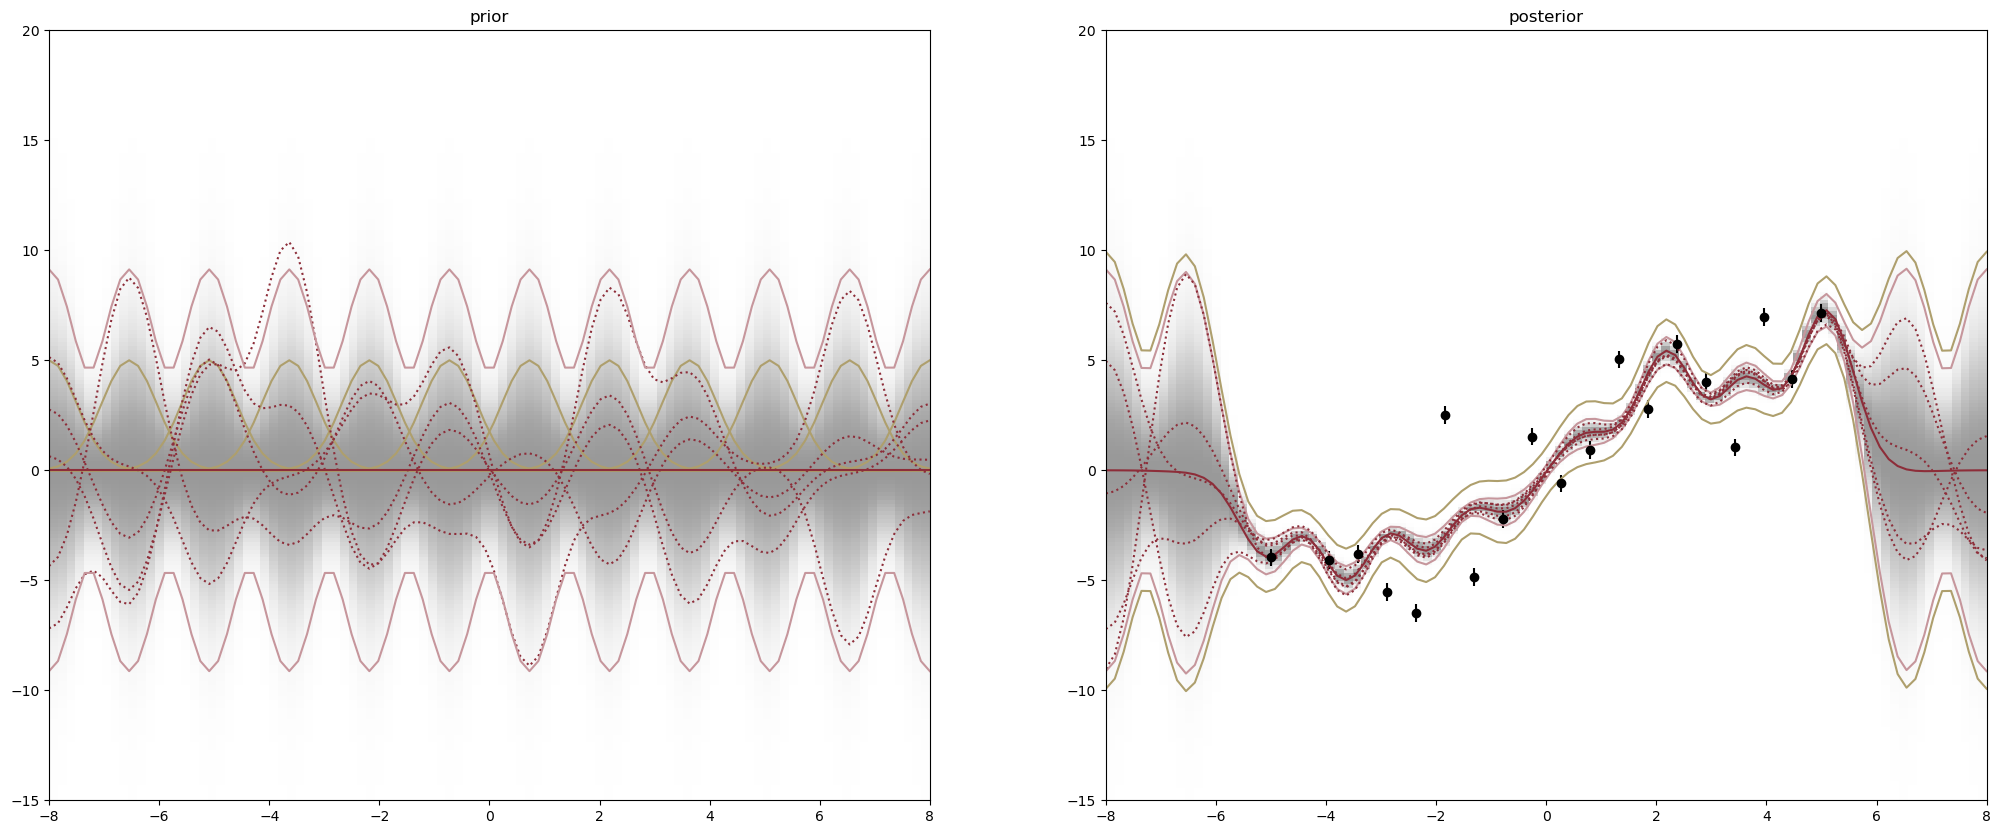

In [31]:
def phi(a):
    return 5 * np.exp(
        -((a - np.linspace(-8, 8, 12).T) ** 2) / 2.0 / 0.5 ** 2
    )  # Gaussian / RBF / SE features

guassian_regression(X,Y,sigma)

### NOTE: This is code of generalized linear model. Here, data is transformed using specific features function such that it can be easily classified using a hyperplane. This can be done using kernel trick. eg: guassian processes and svm

### But if you want to approximate the function without knowing feature functions, then you can use deep neural network. 
### Use SVM for small data and deep neural network for high dimensional data